# Calculating thermal time indices and merging UAV data.

**Name**: Byron Evers<br/>
**Semester**: Spring 2019 <br/>
**Project area**: Agronomy

## Table of contents
1. [Motivation](#BJE_motivation)
2. [Objective](#BJE_objective)
3. [Equations](#BJE_equations)
    * [GDD](#BJE_GDD)
    * [Pdays](#BJE_Pdays)
    * [BMT](#BJE_BMT)
4. [Project Steps](#BJE_examples)
    * [Step 1: Import Modules](#BJE_step1)
    * [Step 2: Download Data](#BJE_step2)
    * [Step 3: Format Data Frame](#BJE_step3)
    * [Step 4: Define User Inputs](#BJE_step4)
    * [Step 5: Calculate Photoperiod](#BJE_step5)
    * [Step 6: Define Growing Season](#BJE_step6)
    * [Step 7: Calculate GDD](#BJE_step7)
    * [Step 8: Calculate Pdays ](#BJE_step8)
    * [Step 9: Calculate BMT](#BJE_step9)
    * [Step 10: Graph Results](#BJE_step10)
    * [Step 11: Merge UAV and Thermal Time Index](#BJE_step11)
5. [Conclusions](#BJE_conclusions)
6. [Self Evaluation](#BJE_self)
7. [References](#BJE_ref)

<a name="BJE_motivation"></a>
## Motivation
- Poland labs current UAV pipeline includes stitching photos and extracting plot level reflectance data through Agisoft software.
- Data received from this process is in either an Excel or csv file. 
- The data set includes reflectance values for 5 individual bands (R,G,B,RE and NIR) and 3 vegetative indices (NDVI, NDRE and GNDVI). 
- Currently a wide range of time scales are used for UAV data analysis. 
    * Days after planting
    * Day of Year
    * Thermal Time
        * GDD
        * Pdays
        * BMT
        
Thermal time indices are important for data analysis between years. However, how thermal time is calculated can also influence reflectance data. Using set values such as a base temperature, maximum temperature and optimum temperature all effect thermal time. Additionally, photo period can also affect the growing stage in many crops. Typically, wheat is not as photo period dependent but in crops such as soybeans it can heavily influence crop development. For this project three thermal time indices were chosen to further explore the differences between these indices.

<a name="BJE_objective"></a>
## Objective

1. Write a python function to calculate three thermal time indices for all UAV collection dates
    * growing degree days (GDD)
    * physiological days (Pdays)
    * biometeorological time (BMT) 
2. Merge all of the UAV reflectance data, plot level phenotypic data and the calculated thermal values into one .csv file.

**I would like to emphasize that the goal of this project is to create a single output file with UAV data and thermal time indices. Calculating UAV indices such as NDVI is already completed by this point. The diagram bellow shows the outline of the entire process. However only steps in green are the objectives of this project.**

<img src= "Fig/diagram.png" alt="sketch_image" width="1000"/>

<a name="BJE_equations"></a>
## Equations

<a name="BJE_GDD"></a>
### Growing Degree Days (GDD):
$$GDD = \sum_{Planting}^{Harvest}(\frac{Tmax+Tmin}{2})-Tbase$$

<a name="BJE_Pdays"></a>
### Physiological Days (Pdays):
$$Pdays = \frac{1}{24}(5*P(T_1)+8*P(T_2)+8*P(T_3)+3*P(T_4))$$
**Where**
* $T_1=Tmin$
* $T_2=\frac{(2*Tmin)+Tmax}{3}$
* $T_3=\frac{Tmin+(2*Tmax)}{3}$
* $T_4=Tmax$

**And P is**
* $P=0$   When $T <=Tmin$
* $P=k*(1-\frac{(T-Topt)2}{(Topt-Tmin)2})$ when $Tmin <= T <=Topt$
* $P=k*(1-\frac{(T-Topt)2}{(Tmax-Topt)2})$ when $Topt <= T <=Tmax$
* $P=0$ when $T >=Tmax$

**And k is**
* $P=0$   When $T <=Tmin$

<a name="BJE_BMT"></a>
### Biometeorological Time
$$BMT = \sum_{Planting}^{Harvest}[a_1(L-a_0) + a_2(L-a_0)^2* {[b_1(Tmax-b_0) + b_2(Tmax-b_0)^2}+{d_1(Tmin-b_0) + d_2(Tmin-b_0)^2]}$$
or for simplicity:
$$BMT = \sum_{Planting}^{Harvest}V_1 {(V_2}+{V_3)}$$
**Where**
* $L$= daily photoperiod
* $a_0$= base daylength
* $b_0$= base temperature
* $a_1, a_2, b_1, b_2, d_1, d_2$ are response coefficients
    * For this project I used the coefficents detailed by Robertson (1968)

<a name="BJE_examples"></a>
## Examples and Operational Code

Thank you for reviewing my project and I appreciate any feedback you can provide. This is a fully functional version that pulls data from KSU Mesonet. If for some reason KSU Mesonet is not working I do have a .csv file with weather data save in the data folder. 
<a name="BJE_step1"></a>
# Step 1: Import needed modules
To run ephm you may need to install it first. To do this please run **pip install ephem** command line or execute the cell bellow.

In [26]:
!pip install ephem

In [27]:
import pandas as pd
import numpy as np
import datetime
import ephem
import matplotlib.pyplot as plt
%matplotlib inline

<a name="BJE_step2"></a>
# Step 2: Download Data from the KSU Mesonet. 
* For this project I am only interested in day interval and there for it is hard coded in to the URL
* Users should edit the stn variable to the station they desire. A list of stations is provided at; http://mesonet.k-state.edu/rest/stationnames/
* Date searches must be formatted as YYYYmmddHHMMSS (year, month, day, hour, minute, second). 
* Currently the start date is 20140101000000, or Jan 1, 2014. Granted that is well beyond the scope of this project, is over kill and may slow the download process. However, I used this to demonstrate the power and time scale flexibility of this project. 
* Similar to the start time the end time, as it is set to the time the user executes the cell, is potentially not useful. However, again here I wanted to demonstrate another way to create inputs for the URL builder.
* In sequential steps the large data frame will reduces to capture only date times of interest.
* Additional documentation can be found at; http://mesonet.k-state.edu/rest/

<a name="Update__inputs"></a>

In [28]:
# Set connection to KS Mesonet
root = 'http://mesonet.k-state.edu/rest/stationdata/?'
stn = 'Manhattan'
start_time = "20140101000000" 
end_time =  datetime.datetime.now().strftime('%Y%m%d%H%M%S') 

In [29]:
# Create url to mesonet
url = root + "stn="+stn+'&int=day'+'&t_start='+start_time+'&t_end='+end_time
url #prints url so user can check format

'http://mesonet.k-state.edu/rest/stationdata/?stn=Manhattan&int=day&t_start=20140101000000&t_end=20190507114939'

<span style="color:red">**The cell below will pull data from KSU Mesonet. This works as long as the mesonet site is operational. Additionally, this can be slow depending on your internet connection, feel free to access data through the URL. However, there is a sample data set saved as a .txt that can be accessed in the cells bellow.**<span>

In [30]:
df = pd.read_csv(url)
print(type(df))
df.head(2)

<class 'pandas.core.frame.DataFrame'>


,TIMESTAMP,STATION,PRESSUREAVG,PRESSUREMAX,PRESSUREMIN,SLPAVG,TEMP2MAVG,TEMP2MMIN,TEMP2MMAX,TEMP10MAVG,...,SOILVR20CM,SOILVR40CM,SOILVR50CM,SOILVR60CM,VWC5CM,VWC10CM,VWC20CM,VWC40CM,VWC50CM,VWC60CM
0,2014-01-02 00:00:00,Manhattan,76.12,76.34,75.94,79.40,-8.75,-12.82,0.10,M,...,M,M,M,M,M,M,M,M,M,M
1,2014-01-03 00:00:00,Manhattan,76.36,76.52,76.14,79.75,-12.45,-17.79,-6.43,M,...,M,M,M,M,M,M,M,M,M,M


<span style="color:red">**If mesonet is working you can skip the next two cells. However, if mesonet is not working or if you want to try the remaining code with a stored source of code please continue.**<span>

In [31]:
dirname = '/Users/bevers/Desktop/Coding/Thermal_Time_Indices/Data/' #change to the working directory where the data is stored
filename ='Manhattan_mesonet.txt'

In [32]:
df = pd.read_csv(dirname + filename)
print(type(df))

<class 'pandas.core.frame.DataFrame'>


**df should now be a pandas.core.frame.DataFrame if not please try to re-upload the data either from the url or directly from the data folder. If you cannot get the data to load properly please contact me.**

<a name="BJE_step3"></a>
# Step 3: Format Data Frame 
* For this project the only columns needs are;
    * Date
    * Station
    * Min daily temperature
    * Max daily temperature
* The cell below selects those columns, renames the columns, interpolates data, reformats the data to the types needed and then shows a 5 row preview of the data. 

In [33]:
# Select colums you want and put in a dataframe
df =df[['TIMESTAMP', 'STATION', 'TEMP2MMIN','TEMP2MMAX']] #selects columns needed
df.rename(columns={'TIMESTAMP':'Date', 'TEMP2MMAX':'Tmax', 'TEMP2MMIN':'Tmin'}, inplace=True) #renames columns 
df['Date'] =  pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.head(5)
print(type(df.Tmin[2]))

<class 'numpy.float64'>


In [34]:
print(type(df.Tmax[4]))

<class 'numpy.float64'>


**For missing data some times Mensonet uses NaN and other times uses M. Regardless of the designation the cell below removes these values**

In [35]:
df[pd.to_numeric(df.Tmax, errors='coerce').isnull()]
df=df[pd.to_numeric(df.Tmax, errors='coerce').notnull()]

In [36]:
df.Tmin = df.Tmin.astype(float)
df.Tmax = df.Tmax.astype(float)
df = df.interpolate()
df.head(5)

,Date,STATION,Tmin,Tmax
0,2014-01-02,Manhattan,-12.82,0.10
1,2014-01-03,Manhattan,-17.79,-6.43
2,2014-01-04,Manhattan,-14.39,6.53
3,2014-01-05,Manhattan,-8.81,3.90
4,2014-01-06,Manhattan,-19.15,-8.74


<a name="BJE_step4"></a>
# Step 4: Define User Inputs
* The inputs needed are;
    * plantDate- this is to start the season of interest. This can be stored as a variable now or entered as a string in the "Growing_season" function that will be defined later. Format of input needs to be YYYY-mm-dd.
    * harvestDate- this is to end the season of interest. This can be stored as a variable now or entered as a string in the "Growing_season" function that will be defined later. Format of input needs to be YYYY-mm-dd.
    * long- this is a decimal degree longitude point for the field of interest. This is used by the ephem module to give the most accurate photoperiod. 
    * lat- this is a decimal degree latitude point for the field of interest. This is used by the ephem module to give the most accurate photoperiod. 
    * tbase- this sets the base temperature for the crop of interest in degrees C. In this case wheat is the crop of interest. Temperatures of 5C and 0C are acceptable but 5 is chosen for this example.
    * k- is a set scale factor for the Pdays equation. This maybe be edited for other crops. 
    * topt- this sets the optimumn growing temperature for the crop of interest in degrees C. For wheat in this example 17C was used.
    * tmax- this sets the maximum growing temperature for the crop of interest in degrees C. For wheat in this example 30C was used.
    
**All of these parameters are designed so that users can adjust them to fit the needs of the individual project**

In [37]:
# Define inputs 
plantDate=np.datetime64('2017-10-10') #set the date your crop was planted
harvestDate=np.datetime64('2018-06-22') #set the date your crop was harvest
# Set your location to be used for photoperiod
lat = '39.127298'
long = '-96.610158' 


# GDD inputs
tbase= 5 #set the base temperature for your given crop

# Pdays input
k= .35 #scale factor 
topt = 17
tmax = 30


# Step 5: Calculate Photoperiod

To complete this the ephem module is used. The output is displayed as decimal hours with the times of sunrise and sunset on a 24 hour clock. Date frame must have the following columns;
* Date
* lat
* long

In [38]:
obs = ephem.Observer()
obs.long = ephem.degrees(long)
obs.lat = ephem.degrees(lat)
date =  df['Date'].dt.strftime('%Y/%m/%d')
sun = ephem.Sun(obs)

rise_data=[]
set_data=[]
photoperiod_data=[]

for i in date:
    obs.date = ephem.Date(i)
    r1 = obs.next_rising(sun)
    s1 = obs.next_setting(sun)
    r1_lt = ephem.Date(r1 - 5 * ephem.hour) #local time 
    (y, mn, d, h, min, s) = r1_lt.tuple()
    rise = ( h + min/60. + s/3600. )
    s1_lt = ephem.Date(s1 - 5 * ephem.hour) #local time
    (y, mn, d, h, min, s) = s1_lt.tuple()
    sunset = ( h + min/60. + s/3600. )
    photoperiod=sunset-rise
    rise_data.append(rise)
    set_data.append(sunset)
    photoperiod_data.append(photoperiod)
    df['Sunrise']= pd.DataFrame(rise_data)
    df['Sunset']= pd.DataFrame(set_data)
    df['PhotoPeriod']= pd.DataFrame(photoperiod_data)   
df.head(5)    

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod
0,2014-01-02,Manhattan,-12.82,0.10,8.759000,18.262868,9.503868
1,2014-01-03,Manhattan,-17.79,-6.43,8.760316,18.277155,9.516839
2,2014-01-04,Manhattan,-14.39,6.53,8.761032,18.291815,9.530783
3,2014-01-05,Manhattan,-8.81,3.90,8.761145,18.306832,9.545687
4,2014-01-06,Manhattan,-19.15,-8.74,8.760654,18.322192,9.561538


<a name="BJE_step6"></a>
# Step 6: Define Growing Season
The function will only return dates that fall within the growing season of interest. When running the function multiple 'sub-data frames" can be created at once for each growing season of interest. For this project data frames df17 and df18 are used to represent the 2017 and 2018 growing seasons. As long as the planting comes before the harvest and the dates are within the limits of the data downloaded from the Mesonet any combination will work. If the selected dates are beyond the limits of the data set the function bellow will return an error. When running this example, I encourage the user to edit the "plant" string date to '1984-07-13' to test the lower limit error. Likewise change the "harvest" string to '2222-06-21' to check the upper limit error.

In [39]:
def Growing_season (plant, harvest, df):
    """
    Sets the growing season form plant to harvest for each growing season 
   
     Input: Requires three inputs;
    1. harvest date string formatted as 'YYYY-MM-DD' this can be in the form of a stored variable or a direct string input
    2. Harvest date, string, formatted as 'YYYY-MM-DD' this can be in the form of a stored variable or a direct string input
    3. Pandas data frame with required date column formatted as 'YYYY-MM-DD'
    
    Output: Pandas data frame. With the dates of the growing season of interest. Recommend to save the ouput as a variable
        
    Byron Evers
    
    2019-03-06 
    """
    plant = np.datetime64(plant)
    harvest = np.datetime64(harvest)
    min_date = df.Date.min()
    min_date = min_date.to_datetime64()
    max_date = df.Date.max()
    max_date = max_date.to_datetime64()
    if min_date > plant:
        print('The planting date ' +str(plant)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
        return('The harvest date ' +str(plant)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
    if min_date > harvest:
        print('The harvest date ' +str(harvest)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
        return('The harvest date ' +str(harvest)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
    if max_date < harvest:
        print('The harvest date ' +str(harvest)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
        return('The harvest date ' +str(harvest)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
    if max_date < plant:
        print('The planting date ' +str(plant)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
        return('The planting date ' +str(plant)+' is beyond the range of the Mesonet data. The mesonet data goes from ' + str(df.Date.min())+ " to " + str(df.Date.max()))
    df = df.drop(df[df.Date < plant].index)
    df = df.drop(df[df.Date > harvest].index)
    return df

In [40]:
#Call the function and store the data as a new data frame. In this example two data frames are created,df17 and df18, for the 2017 and 2018 winter wheat growing season
df17 = Growing_season('2016-10-17','2017-06-21',df)
df18 = Growing_season(plantDate,harvestDate,df)
# For df17 date as a string was used where as df18 used the stored variable from input cell. 
#This is just to demonstrate that either format is accepted with this function.

In [41]:
print(df18.head(5))
print(df17.head(5))

           Date    STATION   Tmin   Tmax   Sunrise     Sunset  PhotoPeriod
1377 2017-10-10  Manhattan   8.28  19.33  7.518620  18.915235    11.396615
1378 2017-10-11  Manhattan   4.16   8.42  7.535063  18.890279    11.355217
1379 2017-10-12  Manhattan   2.26  20.54  7.551600  18.865518    11.313918
1380 2017-10-13  Manhattan   8.91  27.46  7.568234  18.840959    11.272726
1381 2017-10-14  Manhattan  14.20  26.37  7.584965  18.816613    11.231648
           Date    STATION   Tmin   Tmax   Sunrise     Sunset  PhotoPeriod
1019 2016-10-17  Manhattan  15.86  30.81  7.639600  18.739033    11.099432
1020 2016-10-18  Manhattan  18.14  31.95  7.656686  18.715647    11.058961
1021 2016-10-19  Manhattan  11.32  23.25  7.673870  18.692521    11.018651
1022 2016-10-20  Manhattan   8.70  23.45  7.691152  18.669663    10.978511
1023 2016-10-21  Manhattan   6.35  16.82  7.708533  18.647084    10.938551


<a name="BJE_step7"></a>
# Step 7: Calculate GDD
The next cell defines a function to calculate growing degree days. For the purpose of this demonstration going forward df17 and df18 will be treated as separate data frames. I could see the value of applying the Growing_season function last and completing the remaining steps first. However, this can not be accomplished as the thermal times are cumulative and would need to be reset.

In [42]:
def GDD(df):
    """
    Calculates an individual and cumulative value for GDD for each day in the data frame
    
    Input: Pandas data frame. Minimum required columns include:
        Tmax= daily maximum temperature
        Tmin= daily minimum temperature
        Date = date of collection
        
    Output: Pandas data frame. In addition, the columns in the data frame input two additional columns will be calculated and added:
        GDD= The growing degree day value for that individual day
        cum_GDD = The cumulative growing degree day value for all days in the designated growing period.
    
    Byron Evers
    
    2019-03-06
    """
    df['Tbase']=tbase
    tavg =((df.Tmax+df.Tmin)/2)
    values = np.where(tavg < tbase, df.Tbase, tavg).astype(float)
    df['GDD']=(values)-df.Tbase
    df['cum_GDD'] = df.GDD.cumsum()
    return df

**Call the function and override the data frame so the new variables are added**

In [43]:
df17=GDD(df17)
df18=GDD(df18)
df17.head(2) # this just print a small sample of one of the data frames to check that Tbase, GDD and cum_GDD are added to the data frame

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD
1019,2016-10-17,Manhattan,15.86,30.81,7.639600,18.739033,11.099432,5,18.335,18.335
1020,2016-10-18,Manhattan,18.14,31.95,7.656686,18.715647,11.058961,5,20.045,38.380


<a name="BJE_step8"></a>
# Step 8: Calculate Pdays 
The next cell defines a function to calculate physiological days. Physiological days incorporates an optimum and maximum growing temperature to determine growth (Saiyed et al. 2009).

In [44]:
def Pdays(df):
    """
    Calculates an individual and cumulative value for Pdays for each day in the data frame
    
    Input: Pandas data frame. Minimum required columns include:
        Tmax= daily maximum temperature
        Tmin= daily minimum temperature
        Tbase= base growing temperature for given crop
        topt= optimum growing temperature for given crop
        tmax= maximum growing temperature for given crop
        Date = date of collection
        
        
    Output: Pandas data frame. In addition, the columns in the data frame input two additional columns will be calculated and added:
        Pdays= The Pday value for that individual day
        cum_Pdays = The cumulative Pdays value for all days in the designated growing period.
    
    Byron Evers
    
    2019-04-06
    """
    T1=np.where(df.Tmin > tbase, df.Tmin, tbase)
    T4=np.where(df.Tmax > 30, 30, df.Tmax)
    T2=((2*T1) + T4)/2
    T3=((2*T4) + T1)/2
    T =((df.Tmax+df.Tmin)/2)
    df['P'] = np.where(T < topt,(k*(1-((T-topt)*2)/((topt-df.Tmin)*2))),T)
    df['P'] = np.where(T > topt,(k*(1-((T-topt)*2)/((df.Tmax-topt)*2))),df.P)
    df['P'] = np.where(T < tbase,0,df.P)
    df['P'] = np.where(T > tmax,0,df.P)
    df['Pdays']= (1/24)*((5*df.P*T1)+ (8*df.P*T2) + (8*df.P*T3) + (3*df.P*T4))
    df['cum_Pdays']= df.Pdays.cumsum()
    return df

In [45]:
df17=Pdays(df17)
df18=Pdays(df18)
df18.head(2) #This just print a small sample of one of the data frames to check that P, Pdays and cum_Pdays are added to the data frame

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD,P,Pdays,cum_Pdays
1377,2017-10-10,Manhattan,8.28,19.33,7.518620,18.915235,11.396615,5,8.805,8.805,0.478240,8.582609,8.582609
1378,2017-10-11,Manhattan,4.16,8.42,7.535063,18.890279,11.355217,5,1.290,10.095,0.641939,5.651740,14.234349


<a name="BJE_step9"></a>
# Step 9: Calculate BMT
The next several cells defines a function to calculate biometeorological time. The coefficients used for this equation are developed from Robertson (1968). However, these coefficients have been edited as Robertson’s coefficients were developed for spring wheat where vernalization was not needed. Additionally, Robertson’s equation is capped at a 5 point scale. However, I was not able to accomplish this limit. I hypothesize that is due to the length of the winter wheat season comparted to a spring wheat growing season. Rega

The first cell identifies the coefficients for each growth stage. The growth stages used for this project are adapted from Robertson and are defined as follows;

* PE- Planting to Emergence
* EJ- Emergence to Jointing
* JH- Jointing to Heading 
* HS- Heading to Soft Dough
* SR- Soft Dough to Ripe


In [46]:
par = {'a0':0,'a1':0,'a2':0,'b0':0,'b1':0,'b2':0,'d1':0,'d2':0,
       'a0_PE':8.413,'a1_PE':1.005,'a2_PE':0,'b0_PE':0,'b1_PE':0.003512,'b2_PE':0.00005026,'d1_PE':0.000366,'d2_PE':0.000004282,
       'a0_EJ':9.413,'a1_EJ':1.005,'a2_EJ':0,'b0_EJ':0,'b1_EJ':0.003512,'b2_EJ':0.00005026,'d1_EJ':0.000366,'d2_EJ':0.000004282,
       'a0_JH':10.93,'a1_JH':0.9256,'a2_JH':0.06025,'b0_JH':0,'b1_JH':0.0002958,'b2_JH':0,'d1_JH':0.0003943,'d2_JH':0,
       'a0_HS':10.94,'a1_HS':1.389,'a2_HS':1,'b0_HS':0,'b1_HS':0.004458,'b2_HS':0,'d1_HS':0.00003109,'d2_HS':0,
       'a0_SR':14.38,'a1_SR':1.614,'a2_SR':1,'b0_SR':0,'b1_SR':0.007733,'b2_SR':0,'d1_SR':0.0003442,'d2_SR':0,}

In [47]:
def BMT (par,df):
    """
    Calculates an individual and cumulative value for BMT for each day in the data frame
    
    Input: Pandas data frame. Minimum required columns include:
        par = dictonary of coefficents for each stage of development
        Tmax= daily maximum temperature
        Tmin= daily minimum temperature
        PhotoPeriod=daily photo period
        Date = date of collection
        
        
    Output: Pandas data frame. In addition, the columns in the data frame input two additional columns will be calculated and added:
        BMT= The BMT value for that individual day
        cum_BMT = The cumulative BMT value for all days in the designated growing period.
    
    Byron Evers
    
    2019-05-05
    """
    BMT=[0]*len(df)
    cum_BMT=[0]*len(df)
    for i in range(1,len(df)):
        if cum_BMT[i-1] < 1:
            par['a0']=par['a0_PE']
            par['a1']=par['a1_PE']
            par['a2']=par['a2_PE']
            par['b0']=par['b0_PE']
            par['b1']=par['b1_PE']
            par['b2']=par['b2_PE']
            par['d1']=par['d1_PE']
            par['d2']=par['d2_PE']
        elif cum_BMT[i-1] >= 1 and cum_BMT[i-1]< 2:
            par['a0']=par['a0_EJ']
            par['a1']=par['a1_EJ']
            par['a2']=par['a2_EJ']
            par['b0']=par['b0_EJ']
            par['b1']=par['b1_EJ']
            par['b2']=par['b2_EJ']
            par['d1']=par['d1_EJ']
            par['d2']=par['d2_EJ']
        elif cum_BMT[i-1] >= 2 and cum_BMT[i-1]< 2.5:
            par['a0']=par['a0_JH']
            par['a1']=par['a1_JH']
            par['a2']=par['a2_JH']
            par['b0']=par['b0_JH']
            par['b1']=par['b1_JH']
            par['b2']=par['b2_JH']
            par['d1']=par['d1_JH']
            par['d2']=par['d2_JH']
        elif cum_BMT[i-1] >= 2.5 and cum_BMT[i-1]< 3:
            par['a0']=par['a0_HS']
            par['a1']=par['a1_HS']
            par['a2']=par['a2_HS']
            par['b0']=par['b0_HS']
            par['b1']=par['b1_HS']
            par['b2']=par['b2_HS']
            par['d1']=par['d1_HS']
            par['d2']=par['d2_HS']  
        else: 
            par['a0']=par['a0_SR']
            par['a1']=par['a1_SR']
            par['a2']=par['a2_SR']
            par['b0']=par['b0_SR']
            par['b1']=par['b1_SR']
            par['b2']=par['b2_SR']
            par['d1']=par['d1_SR']
            par['d2']=par['d2_SR']
        
        photo =df.PhotoPeriod
        photo= np.where(photo < 0,0,photo)
        tmax =df.Tmax
        tmax= np.where(tmax < 0,0,tmax)
        tmin =df.Tmin
        tmin= np.where(tmin < 0,0,tmin)
        if cum_BMT[i-1] < 0.25:
            v1=1
        else:
            v1=abs((par['a1']*(photo[i]-par['a0'])+(par['a2']*((photo[i]-par['a0'])**2))))
        v2=(par['b1']*(tmin[i]-par['b0'])+(par['b2']*((tmin[i]-par['b0'])**2)))
        v3=(par['d1']*(tmin[i]-par['b0'])+(par['d2']*((tmin[i]-par['b0'])**2)))
        BMT[i]=(v1*(v2+v3))

        T=cum_BMT[i-1]+BMT[i]
        cum_BMT[i]=T
    df['BMT']=BMT  
    df['cum_BMT']=cum_BMT   
    return df

In [48]:
df17=BMT(par, df17)
df18=BMT(par, df18)
df18.tail(5)

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD,P,Pdays,cum_Pdays,BMT,cum_BMT
1628,2018-06-18,Manhattan,25.91,35.68,5.996649,20.920240,14.923591,5,25.795,1559.605,0.000000,0.000000,1039.791298,0.245454,7.364153
1629,2018-06-19,Manhattan,25.24,35.48,5.999099,20.925255,14.926156,5,25.360,1584.965,0.000000,0.000000,1039.791298,0.240520,7.604674
1630,2018-06-20,Manhattan,20.43,30.38,6.002030,20.929786,14.927756,5,20.405,1605.370,0.130138,4.323356,1044.114654,0.195399,7.800073
1631,2018-06-21,Manhattan,17.71,29.77,6.005437,20.933827,14.928390,5,18.740,1624.110,0.165270,5.148303,1049.262957,0.169630,7.969703
1632,2018-06-22,Manhattan,16.16,24.83,6.009312,20.937371,14.928059,5,15.495,1639.605,0.193774,5.225195,1054.488153,0.154667,8.124370


<a name="BJE_step10"></a>
# Step 10: Graph Results
Graphing the data allows for visual comparison. However, as stated in Step 9 the scale of the three thermal time indices are not equivalent. Therefore, when comparing the three indices a scale factor was needed. For this project the scale created was defined as;

$$scale = \frac{cumGDD.max()}{cumBMT.max()}$$

In addition to graphing the thermal time indices horizontal growth stage lines were added to the graph based on GDD values from Miller et al. (2001). A green vertical line was also added to identify the average heading date for each year. This average is an actual ground recorded date that I recorded during the growing season.   

In [49]:
# Add stage predictor GDD for reference
Tillering=420
Flowering=650
GrainFill=930
FullMaturity=1250
# Stages were based of refernce numbers form Miller et al. 
scale17=df17.cum_GDD.max()/df17.cum_BMT.max()
scale18=df18.cum_GDD.max()/df18.cum_BMT.max()

<a name="Update__graph"></a>

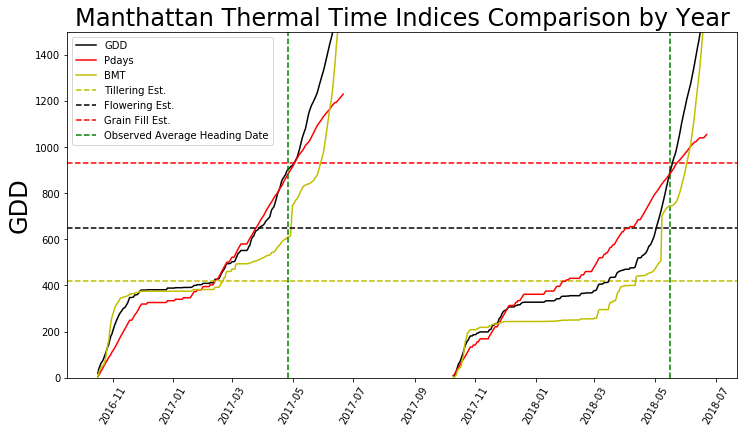

In [51]:
#size plot
plt.figure(figsize=(12,14))


#plot 2017 Data
plt.subplot(2,1,2)
plt.plot(df17.Date,df17.cum_GDD, '-k')
plt.plot(df17.Date,df17.cum_Pdays,'-r')
plt.plot(df17.Date,df17.cum_BMT*(scale17),'-y')
plt.ylabel('GDD', fontsize =24)
plt.xticks(rotation=60)

#plot stage prediction lines
plt.axhline(y=Tillering, color='y', linestyle='--')
plt.axhline(y=Flowering, color='k', linestyle='--')
plt.axhline(y=GrainFill, color='r', linestyle='--')
plt.axvline(x='2017-04-26',linestyle='--', color='green')
plt.axvline(x='2018-05-16',linestyle='--', color='green')

#plot 2018 Data
plt.subplot(2,1,2)
plt.plot(df18.Date,df18.cum_GDD, 'k')
plt.plot(df18.Date,df18.cum_Pdays, 'r')
plt.plot(df18.Date,df18.cum_BMT*(scale18),'-y')
plt.ylabel('GDD', fontsize =24)
plt.xticks(rotation=60)


# edit plot
plt.title('Manthattan Thermal Time Indices Comparison by Year', size=24)

plt.legend(['GDD', 'Pdays','BMT','Tillering Est.','Flowering Est.', 'Grain Fill Est.','Observed Average Heading Date'], loc=2)
axes = plt.gca()
axes.set_ylim([0,1500])

plt.show()

<a name="BJE_step11"></a>
# Step 11: Merge UAV and Thermal Time Index
The final step is to merge UAV data and the newly calculated thermal time indices into one file. This is accomplished by using the pd.merge function in pandas. This can be done as the two sources share "Date" as a similar column. In this example only 2017 Manhattan UAV data is used.

In [ ]:
dirname = '/Users/bevers/Desktop/Coding/Thermal_Time_Indices/Data/'
filename_17 ='2017_RL_NDVI.csv'

In [ ]:
UAV17 = pd.read_csv(dirname + filename_17)
UAV17['Date'] = pd.to_datetime(UAV17.Date)
UAV17.head(5)

In [ ]:
UAV17['UAV_Date'] = pd.to_datetime(UAV17.Date)
df17['Date'] = pd.to_datetime(df17.Date)
finaldf17 = pd.merge(UAV17,df17, on='Date',how='inner')

In [ ]:
finaldf17 = pd.merge(df17, UAV17, on=['Date'], how='inner')
finaldf17 =finaldf17[['Plot_ID','Date','UAV_Date','STATION','NDVI', 'Tmax','Tmin','cum_GDD','cum_Pdays','cum_BMT']] #selects columns needed
finaldf17.cum_BMT= finaldf17.cum_BMT*scale17
finaldf17.tail(5)

In [ ]:
finaldf17.to_csv("2017_UAV_ThermalTime.csv", index=False)

<a name="BJE_conclusions"></a>
## Conclusions

When plotted next to each other in 2017 all the thermal time indices appear to return similar results. In this case the BMT showed more early growth than the other two indices and at the observed heading date had a lower accumulated thermal time. The 2017 growing season overall was warmer than normal with a quick warming period in the spring. This maybe the reason the Pdays and GDD curves are nearly identical in the spring of 2017 as the weighted scale for the optimum temperature in the Pdays equation would have been minimized. 

In 2018 the all the curves show similar shape, but the magnitude of values starts to deviate. Pdays in 2018 appears to over predict growth in the spring. However, the Pday curve matches both BMT and GDD near the recorded average heading date of the trial. Again, this is most likely due to the weighting of the optimum temperature. Unlike 2017 the spring of 2018 was cool early before an extreme heating trend in late spring early summer. This would explain the over prediction of growth early and reduced prediction as temperatures increase. 

Overall this project proves to be beneficial as it provides an automated path to compare and observe thermal time indices across several growing seasons. Moving forward these thermal times indices could be beneficial tools when analyzing UAV reflectance data on a geospatial time scale.

<a name="BJE_self"></a>
## Self Evaluation

Overall, I am pleased with the functionality of the code. However, I realize there is always room for improvement and this project made me aware of some of my limitations and areas I need to improve on. I welcome constructive criticism on any of these self-identified issues along with the identification of any other potential issues. 

1. I am not completely satisfied how I handle missing data from the Mesont. I am not convinced I am interpolating data or if that is even the best way to handle missing data. 
2. I feel some of my functions are heavy in code. In the future I would like to clean them to optimize the code particularly the BMT equation.
3. I would like to increase the flexibility of the user input names. As written now I feel my inputs are to specific and I could see other users having problems replicating my work over a wrong data frame label. 
4. When merging the thermal time and UAV data I would like to develop code that could identify dates where the thermal time was interpolated or missing. I still would merge on that date but having a system that would identify these situations. For example, if a data set was missing data from 4/1/19 to 4/10/19 and a UAV flight was done on 4/7/19 the output would be interpolated data for 4/7 but I would also return 4/10 as that is the nearest actual recorded data. This way the user can compare and make a decision on the best value to use.


<a name="BJE_ref"></a>
## References
Kyratzis Angelos C., Skarlatos Dimitrios P., Menexes George C., Vamvakousis Vasileios F., Katsiotis Andreas, 2017. Assessment of Vegetation Indices Derived by UAV Imagery for Durum Wheat Phenotyping under a Water Limited and Heat Stressed Mediterranean Environment. Frontiers in Plant Science V.8 P 1114

Miller P, Lanier W, Brandt S (2001) Using Growing Degree Days to Predict
Plant Stages, Ag/Extension Communications Coordinator, Communications
Services, Montana State University-Bozeman, Bozeman, MO, pp 1-8.
Available online:
http://msuextension.org/publications/AgandNaturalResources/MT200103AG.
pdf

Robertson, G. W. 1968. A biometeorological time scale for a
cereal crop involving day and night temperatures and photoperiod.
Int. J. Biometeor. 12: 191223.

Saiyed, I., Bullock, P.R., Sapirstein, H.D., Finlay, G.J., Jarvis, C.K., 2009. Thermal time models for estimating wheat phenological development and weather-based relationships to wheat quality. Can. J. Plant Sci. 89, 429–439.

